### 552 Final Project -- Fake News Classifier

### Import libraries

In [62]:
import numpy as np
import pandas as pd
import nltk
from  tensorflow.keras.preprocessing import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn import feature_selection, feature_extraction, svm, pipeline, manifold, preprocessing, metrics
import matplotlib.pyplot as plt

### Prepare datasets

#### Import the generated fake news

In [12]:
temp =  pd.concat([real, df03, df05, df07, df10])

#### Data to Files

### Data Preprocessing

In [81]:
news = pd.read_csv('user_study/user_study_data.csv')

In [82]:
# Download stopwords
stopwords = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leeyvette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
def pre_processing(data):
    
    # Remove special charactors and tokenize
    tokenizedList = list()
    for t in data:
        a = text.text_to_word_sequence(t,
                                  filters='!"#$%&()*+,-./:;<=>?[\\]@^_`{|}~\t\n\r', split=' ')
        tokenizedList.append(a)
    
    # Remove stop words 
    stopwords = nltk.corpus.stopwords.words("english")
    noSWList = list()
    for t in tokenizedList:
        t = [word for word in t if word not in stopwords]
        noSWList.append(t)
        
    # Back to sentences
    b_list = list()
    for a in noSWList:
        b = " ".join(a)
        b_list.append(b)
    
    return b_list

In [84]:
news['clean_news'] = pre_processing(news['text'])

### Method 1: SVM

#### Vectorization (Bag of Words/Chi square feature selection)

In [85]:
def verctorization(train_x, train_y):
    # Create the vocabulary list with max 1000 features
    vectorizer = feature_extraction.text.CountVectorizer(max_features=1000, ngram_range=(1,2))
    
    # Fit the train set in all
    corpus = train_x 
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_
    
    # Get labels
    y = train_y
    X_names = vectorizer.get_feature_names()
    p_value_limit = 0.95
    dtf_features = pd.DataFrame()

    # Feature selection by applying chi square filter
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X_train, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame(
                       {"feature":X_names, "score":1-p, "y":cat}))
        dtf_features = dtf_features.sort_values(["y","score"], 
                        ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    X_names = dtf_features["feature"].unique().tolist()
    
    vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_
    
    return X_train, vectorizer

#### Classifier Performance

In [86]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
cv = StratifiedKFold(n_splits=5, shuffle = True)
classifier = svm.SVC(C=1.0, kernel='linear', probability=True)

In [87]:
def svm_result1(classifier, X, y):  
    
    acc = []
    prec = []
    rec = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    f1 =[]
    
    fig, ax = plt.subplots(figsize = (5,5))
    
    # Cross Validation
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        X_train, vectorizer = verctorization(X[train], y[train])
        
        model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
        model["classifier"].fit(X_train, y[train])

        # Predict the test set
        X_test = X[test].values
        predicted = model.predict(X_test)
        print(predicted)
        
        # Metrics
        accuracy = metrics.accuracy_score(y[test], predicted)
        precision = metrics.precision_score(y[test], predicted)
        recall = metrics.recall_score(y[test], predicted)
        
        acc.append(accuracy)
        prec.append(precision)
        rec.append(recall)
        
        #ROC curve
        viz = metrics.plot_roc_curve(model, X_test, y[test],
                         name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Plot out the ROC Curve with cross validation
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    
    avg_acc = round(np.mean(acc),3)
    avg_prec = round(np.mean(prec),3)
    avg_rec = round(np.mean(rec),3)
    avg_auc = round(mean_auc,3)
        
    print("Avg Accuracy:",  avg_acc)
    print("Avg Precision", avg_prec)
    print("Avg Recall", avg_rec)
    print("Avg Auc:", avg_auc)
    plt.show()
    
    return avg_acc, avg_prec, avg_rec, avg_auc

#### Sample Data

In [88]:
X = news['clean_news'].reset_index(drop=True)
y = news['class'].reset_index(drop=True)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
Avg Accuracy: 0.546
Avg Precision 0.557
Avg Recall 0.95
Avg Auc: 0.488


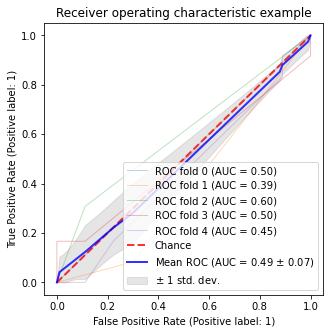

In [89]:
acc, prec, rec, auc = svm_result1(classifier, X, y)

#### Temprature = 0.3

In [101]:
X03 = news03['clean_news'].reset_index(drop=True)
y03 = news03['class'].reset_index(drop=True)

Avg Accuracy: 0.545
Avg Precision 0.549
Avg Recall 0.505
Avg Auc: 0.563


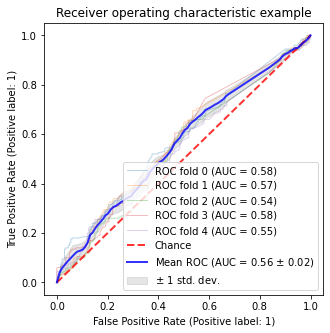

In [102]:
acc03, prec03, rec03, auc03 = svm_result1(classifier, X03, y03)

#### Temprature = 0.5

In [103]:
X05 = news05['clean_news'].reset_index(drop=True)
y05 = news05['class'].reset_index(drop=True)

Avg Accuracy: 0.534
Avg Precision 0.531
Avg Recall 0.566
Avg Auc: 0.552


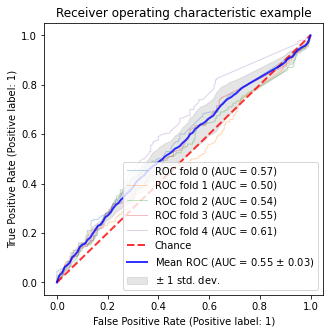

In [104]:
acc05, prec05, rec05, auc05 = svm_result1(classifier, X05, y05)

#### Temperature = 0.7

In [105]:
X07 = news07['clean_news'].reset_index(drop=True)
y07 = news07['class'].reset_index(drop=True)

Avg Accuracy: 0.542
Avg Precision 0.541
Avg Recall 0.56
Avg Auc: 0.556


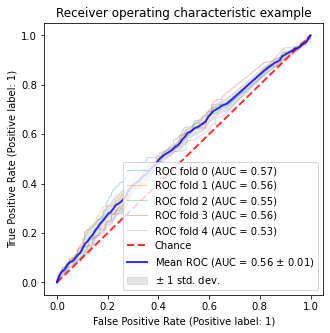

In [106]:
acc07, prec07, rec07, auc07 = svm_result1(classifier, X07, y07)

#### Temperature = 1.0

In [107]:
X10 = news10['clean_news'].reset_index(drop=True)
y10 = news10['class'].reset_index(drop=True)

Avg Accuracy: 0.567
Avg Precision 0.568
Avg Recall 0.569
Avg Auc: 0.59


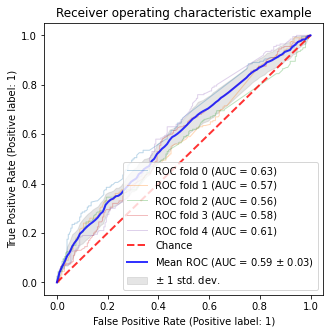

In [108]:
acc10, prec10, rec10, auc10 = svm_result1(classifier, X10, y10)

#### SVM Conclusion